In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from os.path import join
from pathlib import Path
import os

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

from datetime import datetime, timedelta
from suntime import Sun, SunTimeException


from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler


#Метрики
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#Изменим настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

SEED = 692281488

## Анализ датасета

In [3]:
dp = Path("C:/Users/79099/Desktop/Hakaton_GlowByte/first-competition-2/data/")

In [4]:
df_train_orig = pd.read_csv(join(dp, 'train_dataset.csv'), parse_dates=[0])
df_test_orig = pd.read_csv(join(dp, 'test_dataset.csv'), parse_dates=[0])

In [5]:
#Функция для возврата часа в дату
def date_plus_hours_to_index(data):
    data = data.copy()
    data['date'] = data['date'] + pd.to_timedelta(data['time'] , 'H')
    data = data.set_index('date')
    return data

In [6]:
df_train_orig = date_plus_hours_to_index(df_train_orig)
df_test_orig = date_plus_hours_to_index(df_test_orig)

In [7]:
print(f'Значения индекса монотонны: {df_train_orig.index.is_monotonic}')
df_train_orig

Значения индекса монотонны: True


,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,0,481.51,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,19,552.96,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка"


In [8]:
print(f'Значения индекса монотонны: {df_test_orig.index.is_monotonic}')
df_test_orig 

Значения индекса монотонны: True


,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


### Первичный анализ

In [9]:
#список признаков, по которым функция анализа не будет строить гистограммы
exception_list = ['weather_pred', 'weather_fact', 'time']

##### [Funct] Функция для первичного анализа

In [10]:
def data_analyse(data, exception_list = []):
    list_c = data.columns.unique()
    temp = data.copy()
    print(temp.info())
    print('-'* 25)
    if temp.duplicated().sum() == 0:
        print(f'Явных дубликатов нет')
    else:
        print(f'Количество явных дубликатов в датасете:{temp.duplicated().sum()}')
    for col_l in list_c:
        uniq_count = temp[col_l].nunique()
        print('-'* 25)
        print(f'{col_l}')
        print('Уникальные значения')
        print(f'Первые 5 значений: {temp[col_l].sort_values().head(5).unique()}')
        print(f'Последние 5 значений: {temp[col_l].sort_values(ascending = False).head(5).unique()}')
        print(f'Количество уникальных значений: {uniq_count},        процент уникальных значений: {round(uniq_count/len(temp)*100, 2)}%')
        print(f'Количество нулевых значений: {temp[(temp[col_l] == 0) | (temp[col_l] == 0.0)][col_l].count()},        процент нулевых значений: {round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2)}%')
        print(f'Количество пропущенных значений: {temp[col_l].isna().sum()},        процент пропущенных значений:{round(temp[col_l].isna().sum()/len(temp)*100, 2)}%')
        if col_l not in exception_list:
            data[col_l].hist(bins = 100)
            plt.title(col_l)
            plt.show()
    try:
        plt.figure(figsize=(8,8), dpi= 80)
        sns.heatmap(data.corr(),  cmap='Purples', center=0, annot=True)
        plt.title('Зависимость признаков')
        plt.show()
    except:
        print('Коррелирующих признаков нет')
    display(data)
    display(data.describe().round(3))  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          37224 non-null  int64  
 1   target        37224 non-null  float64
 2   temp          37224 non-null  float64
 3   temp_pred     37136 non-null  float64
 4   weather_pred  37136 non-null  object 
 5   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB
None
-------------------------
Явных дубликатов нет
-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.06%
Количество нулевых значений: 1551,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
target
Уникальные значения
Первые 5 значени

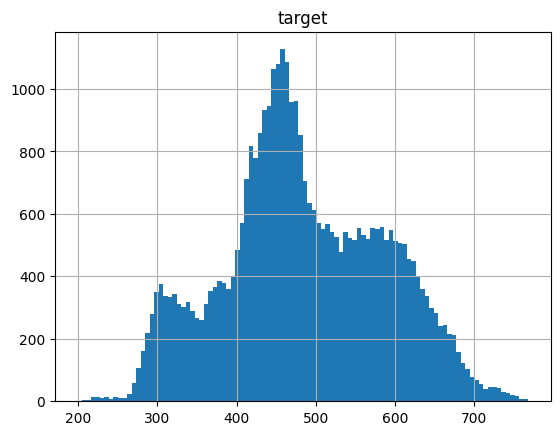

-------------------------
temp
Уникальные значения
Первые 5 значений: [-21.7 -20.9]
Последние 5 значений: [32.5 32.2]
Количество уникальных значений: 474,        процент уникальных значений: 1.27%
Количество нулевых значений: 171,        процент нулевых значений: 0.46%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


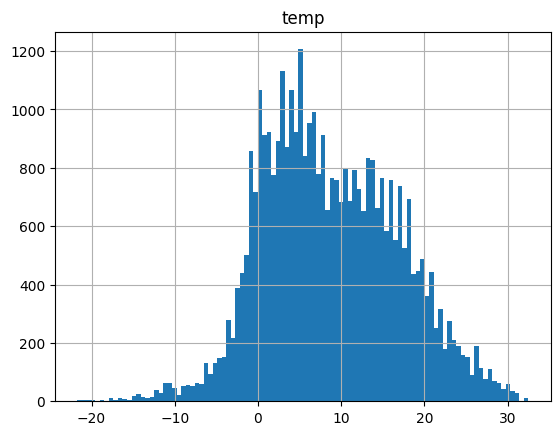

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-20. -19.]
Последние 5 значений: [33. 32.]
Количество уникальных значений: 54,        процент уникальных значений: 0.15%
Количество нулевых значений: 1506,        процент нулевых значений: 4.05%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%


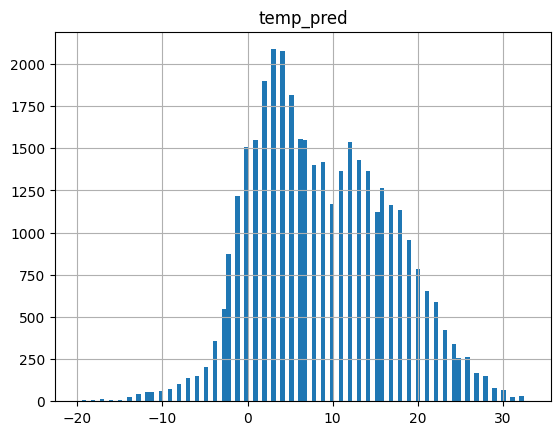

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: [' п/обл, 35% дождь']
Последние 5 значений: ['ясно,ветер']
Количество уникальных значений: 2181,        процент уникальных значений: 5.86%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: [' обл, ветер']
Последние 5 значений: ['ясно,ветерок']
Количество уникальных значений: 580,        процент уникальных значений: 1.56%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 1,        процент пропущенных значений:0.0%


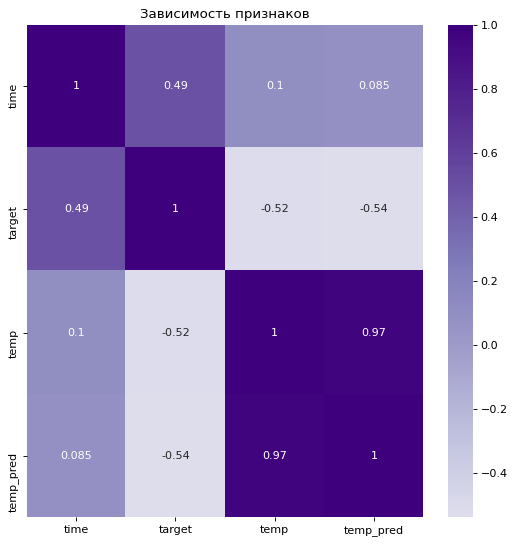

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,0,481.51,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,19,552.96,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка"


,time,target,temp,temp_pred
count,37224.0,37224.0,37224.0,37136.0
mean,11.5,483.731,8.749,8.769
std,6.922,101.459,8.126,8.018
min,0.0,198.982,-21.7,-20.0
25%,5.75,418.951,2.6,3.0
50%,11.5,473.064,7.9,8.0
75%,17.25,561.217,14.7,15.0
max,23.0,767.888,32.5,33.0


In [11]:
data_analyse(df_train_orig, exception_list)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 00:00:00 to 2023-07-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2928 non-null   int64  
 1   target        2928 non-null   float64
 2   temp          2928 non-null   float64
 3   temp_pred     2904 non-null   float64
 4   weather_pred  2904 non-null   object 
 5   weather_fact  2928 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 160.1+ KB
None
-------------------------
Явных дубликатов нет
-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.82%
Количество нулевых значений: 122,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
target
Уникальные значения
Первые 5 значени

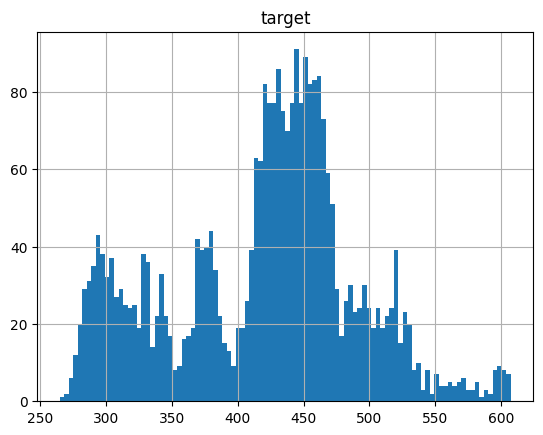

-------------------------
temp
Уникальные значения
Первые 5 значений: [-3.1 -2.9]
Последние 5 значений: [31.7 30.6]
Количество уникальных значений: 270,        процент уникальных значений: 9.22%
Количество нулевых значений: 3,        процент нулевых значений: 0.1%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


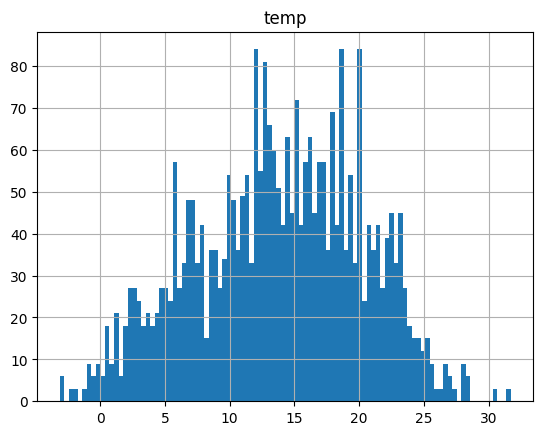

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-3.]
Последние 5 значений: [29.]
Количество уникальных значений: 32,        процент уникальных значений: 1.09%
Количество нулевых значений: 54,        процент нулевых значений: 1.84%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%


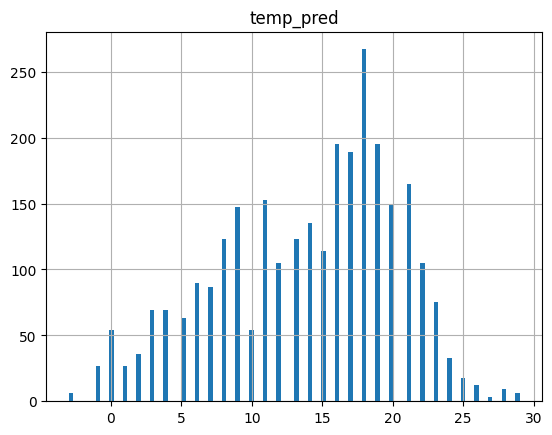

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: ['0']
Последние 5 значений: ['ясно, юго-зап.ветер' 'ясно, штиль']
Количество уникальных значений: 246,        процент уникальных значений: 8.4%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: ['дождь']
Последние 5 значений: ['ясно, хол.ветерок']
Количество уникальных значений: 121,        процент уникальных значений: 4.13%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


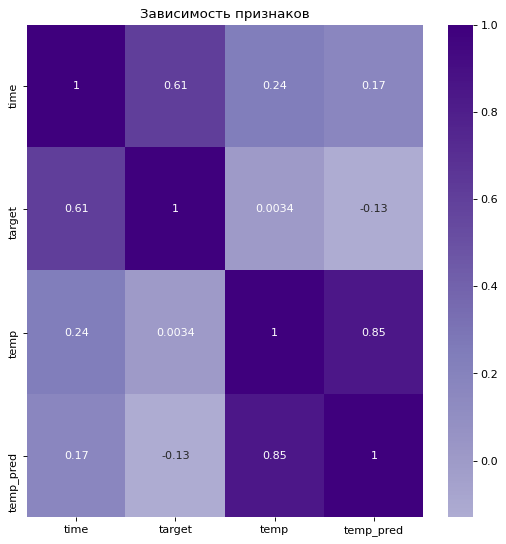

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


,time,target,temp,temp_pred
count,2928.0,2928.0,2928.0,2904.0
mean,11.5,419.467,13.769,13.91
std,6.923,71.393,6.48,6.382
min,0.0,264.819,-3.1,-3.0
25%,5.75,371.384,9.2,9.0
50%,11.5,431.477,14.0,15.0
75%,17.25,462.414,18.7,19.0
max,23.0,607.474,31.7,29.0


In [12]:
data_analyse(df_test_orig, exception_list)

In [13]:
#Посмотрим на динамику среднего значения и среднеквадратичного отклонения в разрезе 30 и 160 дней
def data_std_mean(data, count_rollin):
    data_copy = data.copy()
    data_copy.sort_index(inplace=True)
    data_copy = data_copy.resample('1D').sum() 
    data_copy['mean'] = data_copy['target'].rolling(count_rollin).mean()
    data_copy['std'] = data_copy['target'].rolling(count_rollin).std()
    
    plt.figure(figsize=(20, 6))
    plt.subplot(312)
    data_copy[['target', 'mean', 'std']].plot(ax=plt.gca())
    plt.show()


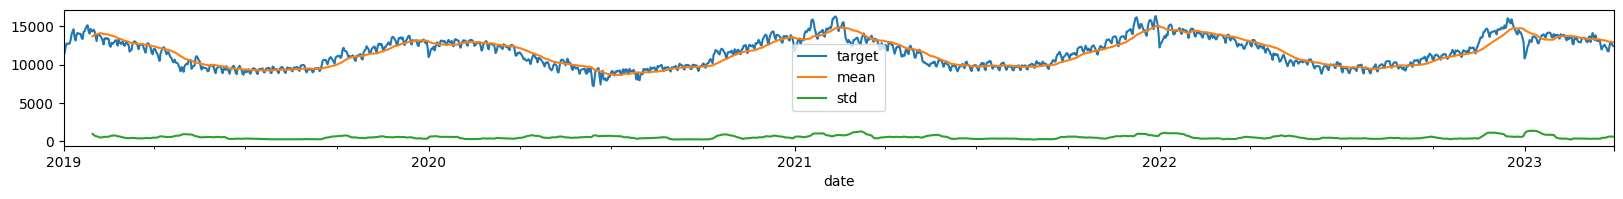

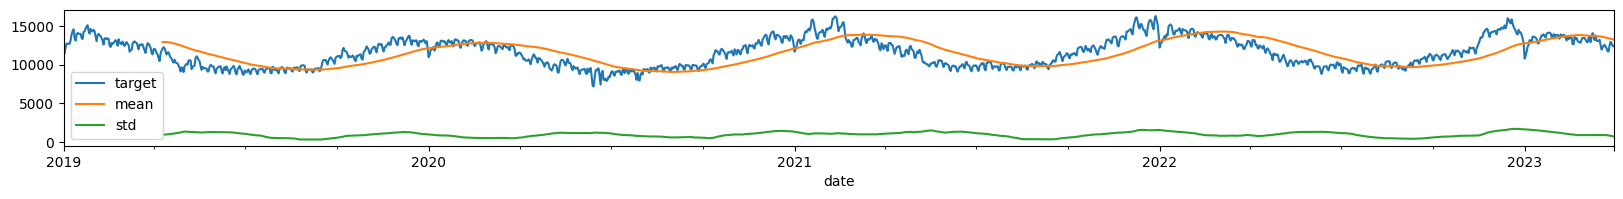

In [14]:
data_std_mean(df_train_orig, 30)
data_std_mean(df_train_orig, 100)

#### Тест Дики-Фуллера на стационарность

In [15]:
ts = df_train_orig['target']
st_test = adfuller(ts, regression = 'ctt')
print('ADF Statistic: %f' % st_test[0])
print('p-value: %f' % st_test[1])
print('Critical Values:')
for key, value in st_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.572234
p-value: 0.005070
Critical Values:
	1%: -4.371
	5%: -3.833
	10%: -3.553


Исходя из полученных результатов, мы можем сделать вывод, что данные являются стационарными. Это означает, что они не имеют тренда или сезонности, и статистические характеристики данных могут быть считаны как постоянные с течением времени. p.s. Но это просто для полноты картины

<b>Сезонность и Тренд

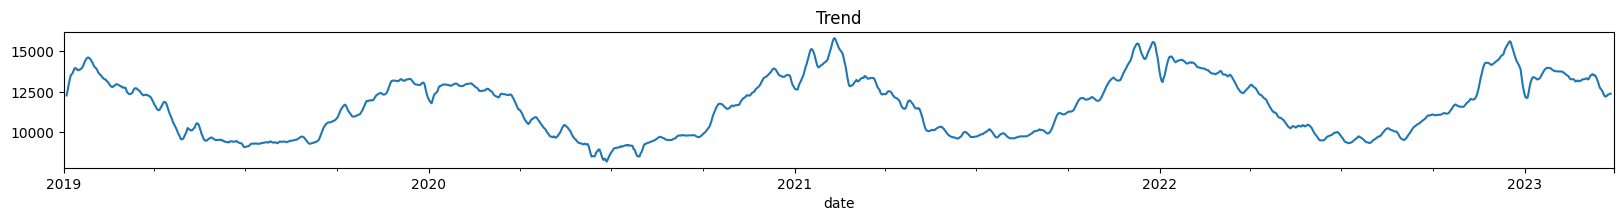

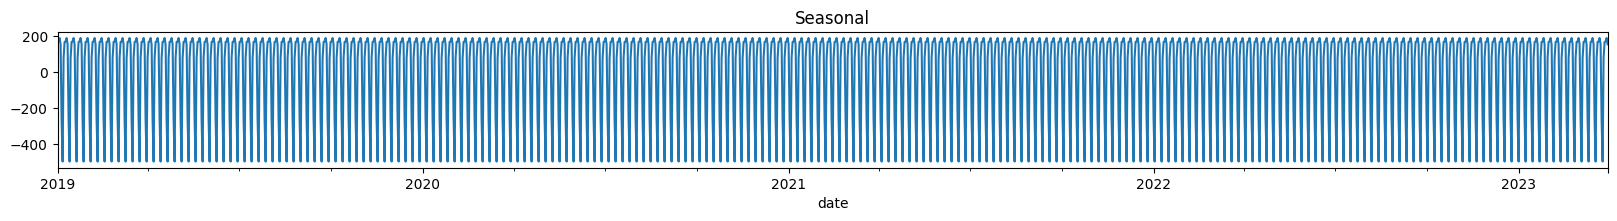

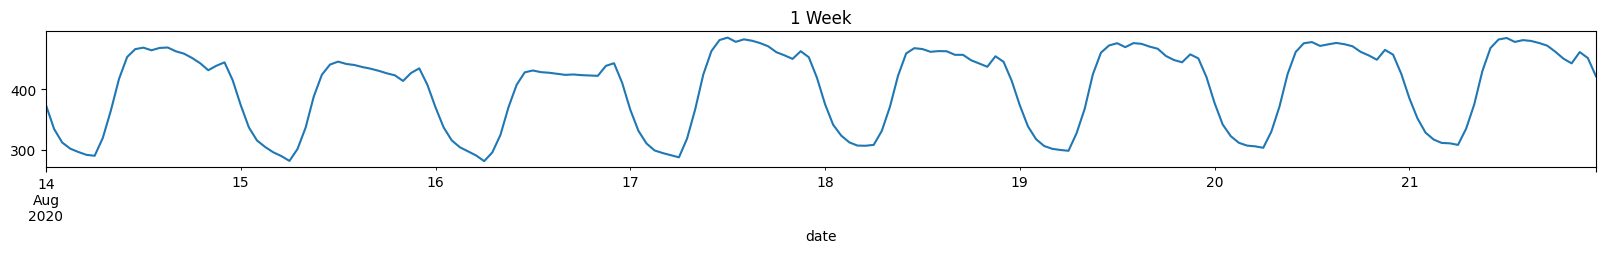

In [16]:
df = df_train_orig['target'].resample('1D').sum() 
decomposed = seasonal_decompose(df) 
# Тренд
plt.figure(figsize=(20, 6))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()
#Сезонность
plt.figure(figsize=(20, 6))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.show()
#1 Неделя
plt.figure(figsize=(20, 6))
plt.subplot(313)
df_train_orig.loc['2020-08-14':'2020-08-21', 'target'].plot(ax=plt.gca())
plt.title('1 Week')
plt.show()

## Добавление признаков

### Время восхода солнца

In [17]:
def sunrise(df):
    latitude = 54.7065
    longitude = 20.511

    sun = Sun(latitude, longitude)

    df['day'] = df.index
    df['sunrise'] = ('2019-01-01 00:00:00')
    df['sunset'] = ('2019-01-01 00:00:00')

    for i in range(len(df_train_orig['day'])):
        df['sunrise'][i] = (sun.get_local_sunrise_time(datetime.date(df['day'][i])) 
                                        - timedelta(hours=1)).strftime('%Y-%m-%dZ%H:%M:%S')
        df['sunset'][i] = (sun.get_local_sunset_time(datetime.date(df['day'][i])) 
                                        - timedelta(hours=1)).strftime('%Y-%m-%dZ%H:%M:%S')
    
    df = df.drop(['day'], axis= 1)

    df['sunset'] = pd.to_datetime(df['sunset'], format='%Y-%m-%dZ%H:%M:%S')
    df['sunrise'] = pd.to_datetime(df['sunrise'], format='%Y-%m-%dZ%H:%M:%S')
    df['sun_time'] = df['sunset'] - df['sunrise']
         
    return df
    
    

    

In [19]:
df_train_orig = sunrise(df_train_orig)

In [20]:
df_train_orig.head(5)

,time,target,temp,temp_pred,weather_pred,weather_fact,sunrise,sunset,sun_time
date,,,,,,,,,
2019-01-01 00:00:00,0,481.51,2.9,2.0,"пасм, ветер",ветер,2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00
2019-01-01 01:00:00,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00
2019-01-01 02:00:00,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00
2019-01-01 03:00:00,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00
2019-01-01 04:00:00,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00


### Обработка импортированных данных

In [21]:
df_true_weather = pd.read_csv(join(dp, 'da_true_weather.csv'), sep=';')

In [22]:
df_train_orig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   time          37224 non-null  int64          
 1   target        37224 non-null  float64        
 2   temp          37224 non-null  float64        
 3   temp_pred     37136 non-null  float64        
 4   weather_pred  37136 non-null  object         
 5   weather_fact  37223 non-null  object         
 6   sunrise       37224 non-null  datetime64[ns] 
 7   sunset        37224 non-null  datetime64[ns] 
 8   sun_time      37224 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(2), timedelta64[ns](1)
memory usage: 3.8+ MB


In [23]:
df_true_weather.head(5)

,Местное время в Храброво / им. императрицы Елизаветы Петровны (аэропорт),T,P0,P,U,DD,Ff,ff10,WW,W'W',c,VV,Td
0,30.09.2023 23:30,14.0,762.3,763.5,94.0,"Ветер, дующий с западо-юго-запада",4,NaN,NaN,NaN,"Рассеянная (40-50%) 840 м, кучево-дождевые облака",10.0 и более,13.0
1,30.09.2023 23:00,14.0,762.3,763.5,94.0,"Ветер, дующий с западо-северо-запада",6,NaN,"Слабый(ая)(ые) ливень (ливни), дождь",NaN,"Разорванная (60-90%) 810 м, кучево-дождевые об...",9.0,13.0
2,30.09.2023 22:30,15.0,762.3,763.5,77.0,"Ветер, дующий с запада",7,NaN,"Слабый(ая)(ые) ливень (ливни), дождь",NaN,"Разорванная (60-90%) 840 м, кучево-дождевые об...",9.0,11.0
3,30.09.2023 22:00,15.0,762.3,763.5,82.0,"Ветер, дующий с западо-северо-запада",3,NaN,NaN,NaN,Рассеянная (40-50%) 810 м,10.0 и более,12.0
4,30.09.2023 21:30,15.0,762.3,763.5,82.0,"Ветер, дующий с запада",5,NaN,NaN,NaN,Рассеянная (40-50%) 930 м,10.0 и более,12.0


In [24]:
def preprocessing(x):
    x.WW = x.WW.str.lower()
    x.WW = x.WW.fillna('нет осадков')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), дождь', 'сильный дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), дождь, снег', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), снег, дождь', 'снег')
    x.WW = x.WW.replace('ливень (ливни), снег, дождь', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) дождь', 'слабый дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) дождь, дымка', 'слабый дождь')
    x.WW = x.WW.replace('сильный(ая)(ые) ливень (ливни), снег, дождь', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) дождь', 'слабый дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) дождь, дымка', 'слабый дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), снег, дымка', 'снег')
    x.WW = x.WW.replace('ливень (ливни), дождь, снег', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) дождь, снег', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) снег', 'снег')
    x.WW = x.WW.replace('снег, дымка', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) снег, дымка', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) снег, дождь, дымка', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) снег, дождь', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), снег', 'снег')
    x.WW = x.WW.replace('ливень (ливни), снег,низовая (метель, буря) снег', 'снег')
    x.WW = x.WW.replace('сильный(ая)(ые) снег', 'снег')
    x.WW = x.WW.replace('снег, дождь, дымка', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) морось', 'слабый дождь')
    x.WW = x.WW.replace('дымка', 'слабый дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) морось, дымка', 'слабый дождь')
    x.WW = x.WW.replace('сильный(ая)(ые) ливень (ливни)', 'сильный дождь')
    x.WW = x.WW.replace('сильный(ая)(ые) ливень (ливни), снег', 'снег')
    x.WW = x.WW.replace('частичный (охватывающий часть аэродрома) туман', 'слабый дождь')
    x.WW = x.WW.replace('замерзающий(ая) (переохлажденный(ая)) туман', 'снег')
    x.WW = x.WW.replace('клочьями туман', 'слабый дождь')
    x.WW = x.WW.replace('сильный(ая)(ые) ливень (ливни), дождь, снег', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), снег, дождь, дымка', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), дождь, небольшой град и/или снежная крупа', 'снег')
    x.WW = x.WW.replace('частичный (охватывающий часть аэродрома) туман, дымка', 'слабый дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), дождь, дымка', 'сильный дождь')
    x.WW = x.WW.replace('морось, дымка', 'слабый дождь')
    x.WW = x.WW.replace('морось, дымка', 'слабый дождь')
    x.WW = x.WW.replace('дымка, дым', 'слабый дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) замерзающий(ая) (переохлажденный(ая)) морось, дымка', 'снег')
    x.WW = x.WW.replace('ливень (ливни), снег, дымка', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) гроза, дождь', 'сильный дождь')
    x.WW = x.WW.replace('ливень (ливни), дождь', 'сильный дождь')
    x.WW = x.WW.replace('снег,низовая (метель, буря) снег', 'снег')
    x.WW = x.WW.replace('клочьями туман, дымка', 'слабый дождь')
    x.WW = x.WW.replace('сильный(ая)(ые) дождь,частичный (охватывающий часть аэродрома) туман', 'сильный дождь')
    x.WW = x.WW.replace('гроза', 'сильный дождь')
    x.WW = x.WW.replace('ливень (ливни), небольшой град и/или снежная крупа', 'снег')
    x.WW = x.WW.replace('поземный туман', 'слабый дождь')
    x.WW = x.WW.replace('дымка,поземный туман', 'слабый дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) дождь, снег, дымка', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) снег,низовая (метель, буря) снег', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) замерзающий(ая) (переохлажденный(ая)) морось', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) снег, слабый(ая)(ые) замерзающий(ая) (переохлажденный(ая)) дождь', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), снег,низовая (метель, буря) снег', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), небольшой град и/или снежная крупа', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) снег,частичный (охватывающий часть аэродрома) туман, дымка', 'снег')
    x.WW = x.WW.replace('дымка,клочьями туман', 'слабый дождь')
    x.WW = x.WW.replace('дождь, дымка', 'слабый дождь')
    x.WW = x.WW.replace('сильный(ая)(ые) ливень (ливни), снег,низовая (метель, буря) снег', 'снег')
    x.WW = x.WW.replace('сильный(ая)(ые) снег,низовая (метель, буря) снег', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), дождь, туман', 'сильный дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) замерзающий(ая) (переохлажденный(ая)) дождь, дымка', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) ливень (ливни), снег, небольшой град и/или снежная крупа', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) дождь, туман', 'слабый дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) морось,частичный (охватывающий часть аэродрома) туман, дымка', 'слабый дождь')
    x.WW = x.WW.replace('слабый(ая)(ые) замерзающий(ая) (переохлажденный(ая)) дождь', 'снег')
    x.WW = x.WW.replace('слабый(ая)(ые) снег, поземок, снег', 'снег')
    x.WW = x.WW.replace('снег, поземок, снег', 'снег')
    x.WW = x.WW.replace('дым', 'слабый дождь')
    x.WW = x.WW.replace('снег, дождь', 'снег')
    x.WW = x.WW.replace('дождь, снег', 'снег')
    x.WW = x.WW.replace('туман', 'слабый дождь')
    x.WW = x.WW.replace('поземок, снег', 'снег')
    x.WW = x.WW.replace('гроза, дождь', 'сильный дождь')
    return x

In [25]:
def processing_table(df):
    df.rename(columns = {'Местное время в Храброво / им. императрицы Елизаветы Петровны (аэропорт)':'date'}, inplace = True )
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df = df.sort_values(by='date')
    df = df.set_index('date')
    df = preprocessing(df)
    return df
    
    
    


In [26]:
df_true_weather = processing_table(df_true_weather) 

In [27]:
df_true_weather.head(5)

,T,P0,P,U,DD,Ff,ff10,WW,W'W',c,VV,Td
date,,,,,,,,,,,,
2019-01-01 00:00:00,2.0,763.8,765.0,87.0,"Ветер, дующий с юго-юго-запада",7,NaN,нет осадков,NaN,Нет существенной облачности,10.0 и более,0.0
2019-01-01 00:30:00,3.0,763.1,764.3,81.0,"Ветер, дующий с юго-юго-запада",7,12.0,нет осадков,NaN,Нет существенной облачности,10.0 и более,0.0
2019-01-01 01:00:00,3.0,762.3,763.5,81.0,"Ветер, дующий с юго-запада",8,13.0,нет осадков,NaN,Нет существенной облачности,10.0 и более,0.0
2019-01-01 01:30:00,3.0,762.3,763.5,81.0,"Ветер, дующий с юго-запада",8,NaN,слабый дождь,NaN,Разорванная (60-90%) 840 м,10.0 и более,0.0
2019-01-01 02:00:00,3.0,761.6,762.8,87.0,"Ветер, дующий с юго-запада",9,14.0,слабый дождь,NaN,"Разорванная (60-90%) 360 м, сплошная (100%) 750 м",10.0 и более,1.0


### Давление, влажность, точка росы, осадки

In [28]:
def pressure(df):
    df = pd.merge(df, df_true_weather[['P', 'U', 'Td','WW']], left_index=True, right_index=True)
    return df

In [29]:
df_train_orig = pressure(df_train_orig)

In [30]:
df_train_orig

,time,target,temp,temp_pred,weather_pred,weather_fact,sunrise,sunset,sun_time,P,U,Td,WW
date,,,,,,,,,,,,,
2019-01-01 00:00:00,0,481.51,2.9,2.0,"пасм, ветер",ветер,2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00,765.0,87.0,0.0,нет осадков
2019-01-01 01:00:00,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00,763.5,81.0,0.0,нет осадков
2019-01-01 02:00:00,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00,762.8,87.0,1.0,слабый дождь
2019-01-01 03:00:00,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00,761.2,93.0,2.0,слабый дождь
2019-01-01 04:00:00,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019-01-01 09:02:00,2019-01-01 16:22:00,0 days 07:20:00,759.7,93.0,3.0,слабый дождь
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,19,552.96,7.9,6.0,"пасм, 61%","пасм, дымка",2023-03-31 06:14:00,2023-03-31 19:12:00,0 days 12:58:00,748.5,100.0,7.0,нет осадков
2023-03-31 20:00:00,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка",2023-03-31 06:14:00,2023-03-31 19:12:00,0 days 12:58:00,748.5,100.0,6.0,нет осадков
2023-03-31 21:00:00,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка",2023-03-31 06:14:00,2023-03-31 19:12:00,0 days 12:58:00,748.5,100.0,6.0,нет осадков
